In [1]:
## Loading neccessary libraries 

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import pandas as pd
import random
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import seaborn as sns


## Constant variables which will be updated in newer versions of the model to parameters of the Country class 
## All variables are by default unitless, but have assgined units for beeter illustration


COST_INSULATION = 0.45 # cost of insulating square foot, can be considered cents of euro
TRESHOLD_LEVEL = 0.25  # treshold level for arrears 
RESTORATION_COST = 1122 * COST_INSULATION # Restoration cost of one household, 1122 is average european house size in square feet
DWELLING_RESTORATION_LIMIT = 900 # upper limit of restoring one dwelling 
RESTORATION_DWELLING_REDUCTION = 0.5 # reduction of dwelling effectivity
RESTORATION_STEP = 7 # the step of simulation in which restoration policy executes
GRANULARITY = 'MONTH'  ## in further version of the model can be used to select granularity of studied steps
INABILITY_TRESHOLD = 0.1 # percentage of disposable income allocated to energy utility bills treshold, above which household is marked as in "inability" to keep dwelling adequately warm
ARREARS_TRESHOLD = 0.75 # similar to inability, but decisive treshold for arrears 
MPS_VALUES = [0.1, 0.13, 0.17, 0.20, 0.25] # Marginal Propensity to save by qunitiles from lowest to highest 
SHOCK_INDEX = 0  # price index to which shokc shall be applied, 0 is yellow fuel, 1 brown fuel  
SHOCK_MAGNITUDE = 0.5 # magnitude of price shock in percentage 
SHOCK_STEP = 5 # step in which price shock happens, if the schock is executed in the simulation 
ALLOWENCE_CHEQUE = 50 # amount of the allowence cheque assigned to households 
RESTORATION_BUDGET = 12000 # overall budget allocated to restoration policy 
ALLOWENCE_BUDGET = 50000 # overall budget allocated to allowence policy 
ALLOWENCE_FROM = 9 # step in which allowence policy is excercissed

class Household(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, inability=False, restoration_recieved = False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income # disposalble income of household
        self.dwelling = dwelling # energy intensity of household 
        self.inability = inability # boolean denoting weather household is in inability 
        self.savings = 0  # savings is initialized as 0 
        self.arrears = 0 # amount 
        self.x = random.uniform(0, 1) # random x coordinate to visualize agents 
        self.y = random.uniform(0, 1) # random y coordonate to visualize agents  
        self.restoration_recieved = restoration_recieved # boolean to denote weather agent recieved restoration help in restoration program 
        self.allowence_recieved = False # wheather household recieved allowence under allowence program
        self.allowence_cheques_sum = 0 # total amount of allowence cheques assigned to agent 
        self.mps = 0 # marginal propensity to save initialized to zero and later changed accordignly to income quintile 
        self.daai = 0 # disposable income after allowences 

    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling)
    
    # Assign marginal propensity to save 
    def update_mps(self):
        # Get all agent incomes
        incomes = [a.disposable_income for a in self.model.schedule.agents]

        # Calculate the quintile thresholds
        thresholds = np.quantile(incomes, [0.2, 0.4, 0.6, 0.8]) # artbitratly set income tresholds 

        # Determine which quintile the agent's income belongs to
        quintile = np.digitize(self.disposable_income, thresholds)

        # Set the MPS based on the quintile
        self.mps = MPS_VALUES[quintile]
        
    def step(self):
        """Update the agent's savings in a step."""
        # Calculate energy costs
        energy_costs = self.energy_cost

        self.update_mps()

        # Check if the agent is in arrears
        if energy_costs > self.disposable_income * ARREARS_TRESHOLD:  # now considering arrears if energy cost exceeds ARREARS_TRESHOLD of disposable income
            self.arrears += energy_costs
        else:
            self.savings += (self.disposable_income - energy_costs) * self.mps

        # If the agent has arrears
        if self.arrears > 0:
            if self.savings >= self.arrears:  # and if savings can cover it
                self.savings -= self.arrears
                self.arrears = 0 # clear the arrears amount
            else:  # if savings cannot cover it
                self.arrears = self.arrears - self.savings  # set arrears to remaining amount
                self.savings = 0

        self.inability = self.energy_cost > self.disposable_income * INABILITY_TRESHOLD  # agent is in inability state if energy costs exceed 10% of income

        # Update disposable income based on growth rate
        growth_rate = np.random.uniform(self.model.growth_boundaries[0], self.model.growth_boundaries[1])
        self.disposable_income *= (1 + growth_rate)


class Country(Model):
    
    # method to create such set of incomes which are close or equall to set gini coefficinet
    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))


    # method is using the target gini coefficient to assign incomes according to gamma distribution 
    # The process find the distribution of incomes itteratively 
    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        raise Exception(f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}")
    

    # Restoration program method sorts the agents by incomes and if the program is executed restores dwelling of agents sorted by income and dwelling intensity 
    def restoration_program(self):

        global RESTORATION_DWELLING_REDUCTION

        # Sort the agents by income in ascending order
        sorted_agents = sorted(self.schedule.agents, key=lambda agent: (agent.disposable_income, -agent.dwelling)) # agents sorted by ascending income and descending dwelling 

        for agent in sorted_agents:
            if self.restoration_budget >= self.restoration_cost:
                # Assign the restoration
                agent.restoration_recieved = True

                agent.dwelling *= (1- RESTORATION_DWELLING_REDUCTION)

                # Deduct the restoration cost from the budget
                self.restoration_budget -= self.restoration_cost
            else:
                # If the budget is not sufficient for another restoration, break the loop
                break

    # allowence program works in similar manner to restoration program but sorts the agents only by income        
    def allowence_program(self):

        # Get a list of all agents' incomes
        incomes = [agent.disposable_income for agent in self.schedule.agents]

        # Compute the 40th percentile of income, which will serve as the cutoff
        income_cutoff = np.percentile(incomes, 40)

        # Sort the agents by income in ascending order
        sorted_agents = sorted(self.schedule.agents, key=lambda agent: (agent.disposable_income))

        for agent in sorted_agents:
            # Check if the agent's income is below the cutoff
            if agent.disposable_income <= income_cutoff and agent.inability:
                if self.allowence_budget >= self.allowence_cheque:
                    # Assign the allowance
                    agent.allowence_recieved = True
                    agent.allowence_cheques_sum += self.allowence_cheque
                    agent.daai = agent.disposable_income - self.allowence_cheque 
                    agent.disposable_income += self.allowence_cheque

                    # Deduct the restoration cost from the budget
                    self.allowence_budget -= self.allowence_cheque
                else:
                    # If the budget is not sufficient for another restoration, break the loop
                    agent.daai = agent.disposable_income
                    break
            else:
                agent.daai = agent.disposable_income

    @staticmethod
    def assign_inability(agents, inability_start):
        """
        Assigns the inability to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_unable = int(inability_start * num_agents)
        inability_per_quintile = np.array([2, 1.6, 1.2, 0.8, 0]) # These values are set arbitrarily 
        inability_per_quintile *= num_unable / np.sum(inability_per_quintile)
        inability_per_quintile = inability_per_quintile.astype(int)

        assigned_unable = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_unable_quintile = min(inability_per_quintile[i], len(quintile))
            unable_agents = np.random.choice(quintile, num_unable_quintile, replace=False)
            for agent in unable_agents:
                agent.inability = True
            assigned_unable += num_unable_quintile

        # Assign remaining inability if any
        i = 0
        while assigned_unable < num_unable:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.inability]
            if quintile:
                agent = np.random.choice(quintile)
                agent.inability = True
                assigned_unable += 1
            else:
                i += 1

    @staticmethod
    def assign_arrears(agents, arrears_start):
        """
        Assigns the arrears to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_arrears = int(arrears_start * num_agents)
        arrears_per_quintile = np.array([2, 1.6, 0, 0, 0])
        arrears_per_quintile *= num_arrears / np.sum(arrears_per_quintile)
        arrears_per_quintile = arrears_per_quintile.astype(int)

        assigned_arrears = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_arrears_quintile = min(arrears_per_quintile[i], len(quintile))
            arrears_agents = np.random.choice(quintile, num_arrears_quintile, replace=False)
            for agent in arrears_agents:
                agent.arrears = 2 * ARREARS_TRESHOLD * agent.disposable_income  # assign 0.6 * disposable_income
            assigned_arrears += num_arrears_quintile

        # Assign remaining arrears if any
        i = 0
        while assigned_arrears < num_arrears:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.arrears > 0]
            if quintile:
                agent = np.random.choice(quintile)
                agent.arrears = ARREARS_TRESHOLD * agent.disposable_income  # assign 0.6 * disposable_income
                assigned_arrears += 1
            else:
                i += 1


    @staticmethod
    def assign_dwelling(agents, energy_price):
        """
        Assigns the dwelling to the agents.
        """
        buffer = 0.02  # 2% buffer or margin
        all_incomes = [agent.disposable_income for agent in agents]
        quintile_thresholds = np.quantile(all_incomes, [0.2, 0.4])  # Calculate income thresholds for the bottom two quintiles
        for agent in agents:
            min_dwelling, max_dwelling = 500, 2000
            if agent.inability:
                min_dwelling = max(min_dwelling, int(np.ceil((agent.disposable_income * (INABILITY_TRESHOLD + buffer)) / energy_price)))
            else:
                max_dwelling = min(max_dwelling, int((agent.disposable_income * (INABILITY_TRESHOLD - buffer)) / energy_price))

            # Generate a list of feasible dwelling values
            feasible_dwelling = list(range(min_dwelling, max_dwelling + 1))

            # If the list is not empty, select a random dwelling from the list
            if feasible_dwelling:
                agent.dwelling = np.random.choice(feasible_dwelling)
            else:
                agent.dwelling = min_dwelling  # fallback to the min_dwelling if no other options

            # Check income quintile of the agent and if in inability state, increase dwelling size
            if agent.disposable_income < quintile_thresholds[1] and agent.inability:  # If in bottom two quintiles and inability is True
                agent.dwelling = min(max_dwelling, int(agent.dwelling * 1.25))  # Increase dwelling size by 25%, but not more than max_dwelling

    def __init__(self, N, median_income, min_disposal, gini_target, inability_target, arrears_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound, restoration_ACTIVE = False, allowence_ACTIVE = False, price_shock = False):
        self.num_agents = N # total number of agents 
        self.median_income = median_income # median income used for gini distribution target
        self.min_disposal = min_disposal # minimal disposable income used for fini distribution target
        self.gini_target = gini_target # target of Gini index distribution 
        self.inability_target = inability_target # share of agents with inability in the first step od the simulation 
        self.growth_boundaries = growth_boundaries # how much does disposable income grows every step 
        self.prices = prices # prices of each fuel 
        self.shares_p = shares_p # shares of each fuel in the energy mix of the Country 
        self.growth_rate_lower_bound = growth_rate_lower_bound # lower bounds of growth rates of fuel prices 
        self.growth_rate_upper_bound = growth_rate_upper_bound # upper bound ...
        self.price_shock = price_shock # boolean of introducing price shock in the Country 
        self.restoration_ACTIVE = restoration_ACTIVE # Boolean activating restoration program 
        self.allowence_ACTIVE = allowence_ACTIVE # Boolean activating allowence program 
        self.restoration_cost = RESTORATION_COST # viz Variables  
        self.restoration_budget = RESTORATION_BUDGET # viz Variables 
        self.allowence_budget = ALLOWENCE_BUDGET # viz Variables 
        self.allowence_cheque = ALLOWENCE_CHEQUE # viz Variables 
        self.arrears_target = arrears_target # targeted share of arrears assigned to households 
        
        
        # Schedule randomly initializes agents 
        self.schedule = RandomActivation(self)

        # datacolelctor collects data for each step simulated 
        self.datacollector = DataCollector(
        agent_reporters={"Dwelling": "dwelling", 
                        "Income": "disposable_income",
                        "Inability": "inability",
                        "Savings":"savings",
                        "X":"x",
                        "Y":"y",
                        "MPS":"mps",
                        "DAAI":"daai",
                        "Allowence":"allowence_cheques_sum",
                        "Restoration Aid Recieved":"restoration_recieved",
                        "Arrears":"arrears",
                        "EnergyCost": "energy_cost"},
        model_reporters = {
                        "Inability": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents,
                        "Arrears": lambda model: sum(agent.arrears for agent in model.schedule.agents) / model.num_agents,
                        "Allowences": lambda model: sum(agent.allowence_cheques_sum for agent in model.schedule.agents) / model.num_agents,
                        "Energy Price": lambda model: model.energy_price,
                        "Price Yellow Fuel": lambda model: model.prices[0],
                        "Price Brown Fuel": lambda model: model.prices[1],
                        "Average Dwelling Over Time": lambda model: sum(agent.dwelling for agent in model.schedule.agents) / model.num_agents,
                        "Restorations": lambda m: sum([agent.restoration_recieved for agent in m.schedule.agents])}
                        )

        # Generate disposable incomes and assign dwelling and technology
        incomes = self.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)

        # initial energy price calculated as product of prices and share of each fuel in fuel mix
        self.initial_energy_price = np.dot(self.prices, self.shares_p)

 
        # Create agents
        agents = []
        for i in range(self.num_agents):
            a = Household(i, self, disposable_income=incomes[i], dwelling=0, inability=False)
            agents.append(a)

        # apply the constructed methods to agents 
        self.assign_inability(agents, self.inability_target)
        self.assign_dwelling(agents, self.energy_price)
        self.assign_arrears(agents, self.arrears_target)
        self.assign_mps(agents)

        # Add agents to the model
        for a in agents:
            self.schedule.add(a)

    @staticmethod
    def assign_mps(agents):
        """
        Assigns the MPS to the agents based on their income quintile.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile_agents = agents[start:end]
            for agent in quintile_agents:
                agent.mps = MPS_VALUES[i]

    @property
    def energy_price(self):
        """Calculate and return the current energy price."""
        return np.dot(self.prices, self.shares_p)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)  # Collect data before updating the prices

        # Update prices based on unique growth rates
        growth_rates = np.random.uniform(self.growth_rate_lower_bound, self.growth_rate_upper_bound)

        self.prices = self.prices * (1 + growth_rates)

        if self.schedule.steps == SHOCK_STEP and self.price_shock == True:
            self.prices[SHOCK_INDEX] *= (1 + SHOCK_MAGNITUDE)

        # Execute the restoration program if it is enabled
        if self.schedule.steps == RESTORATION_STEP and self.restoration_ACTIVE:
            self.restoration_program()

        if self.schedule.steps >= ALLOWENCE_FROM and self.allowence_ACTIVE:
            self.allowence_program()

        self.schedule.step()

N, median_income, min_disposal, gini_target, inability_target, arrears_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound, restoration_budget, restoration_ACTIVE = False

In [2]:

model = Country(1000, 1700, 900, 0.30, 0.2, 0.07, [0,0.05], np.array([0.2, 0.06]), np.array([0.7, 0.3]), np.array([-0.01, -0.01]), np.array([0.02, 0.01]), allowence_ACTIVE = True, restoration_ACTIVE= True, price_shock= True)
 
for i in range(15):
    model.step()


agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()


In [3]:
agent_data[agent_data['Restoration Aid Recieved'] == True]

Dwelling       Income  Inability      Savings         X  \
Step AgentID                                                            
8    92          250.0  1012.830031      False   691.227461  0.627536   
     107         250.0  1008.349412      False     0.000000  0.986362   
     122         515.5  1011.080393       True   613.747888  0.084114   
     163         250.0  1017.886149      False   716.798054  0.966816   
     166         250.0  1007.422038      False   721.927730  0.485324   
...                ...          ...        ...          ...       ...   
14   810        1000.0  1472.904039       True  1115.375178  0.654915   
     813         250.0  1159.024859      False     0.000000  0.678953   
     982         250.0  1114.662349      False  1243.066910  0.173017   
     993         250.0  1159.382005      False  1312.427816  0.792996   
     584         250.0  1097.724719      False     0.000000  0.297175   

                     Y   MPS         DAAI  Allowence  \
Step AgentID                                           
8    92       0.134293  0.10     0.000000          0   
     107      0.488724  0.10     0.000000          0   
     122      0.635770  0.10     0.000000          0   
     163      0.055200  0.10     0.000000          0   
     166      0.205753  0.10     0.000000          0   
...                ...   ...          ...        ...   
14   810      0.864162  0.13  1337.339917        250   
     813      0.631032  0.10  1133.392536          0   
     982      0.008536  0.10  1070.714400          0   
     993      0.663740  0.10  1154.467959          0   
     584      0.494390  0.10  1092.784236          0   

              Restoration Aid Recieved     Arrears  EnergyCost  
Step AgentID                                                    
8    92                           True    0.000000   58.752111  
     107                          True  676.117881   58.752111  
     122                          True    0.000000  121.146852  
     163                          True    0.000000   58.752111  
     166                          True    0.000000   58.752111  
...                                ...         ...         ...  
14   810                          True    0.000000  247.121527  
     813                          True   31.255024   61.780382  
     982                          True    0.000000   61.780382  
     993                          True    0.000000   61.780382  
     584                          True   69.666562   61.780382  

[161 rows x 12 columns]

In [4]:
# agent_data[agent_data['Allowence'] > 0]

In [5]:
# import matplotlib.pyplot as plt
# from ipywidgets import interact


# # reset index to make X, Y, Inability into columns
# df = agent_data.reset_index()

# def plot_step(step):
#     df_step = df[df['Step'] == step]
#     fig, ax = plt.subplots()
#     colors = ['red' if inability else 'green' for inability in df_step['Inability']]
#     ax.scatter(df_step['X'], df_step['Y'], color=colors)
#     plt.show()

# # create slider for steps
# interact(plot_step, step=(0, df['Step'].max()))

In [6]:
agent_id_8_data = agent_data.xs(915, level="AgentID")
agent_id_8_data

,Dwelling,Income,Inability,Savings,X,Y,MPS,DAAI,Allowence,Restoration Aid Recieved,Arrears,EnergyCost
Step,,,,,,,,,,,,
0,541.0,2239.045357,False,0.000000,0.976877,0.793968,0.2,0.000000,0,False,0.0,85.478000
1,541.0,2342.308659,False,430.736458,0.976877,0.793968,0.2,0.000000,0,False,0.0,85.363067
2,541.0,2350.350698,False,882.070602,0.976877,0.793968,0.2,0.000000,0,False,0.0,85.637940
3,541.0,2357.500685,False,1334.815381,0.976877,0.793968,0.2,0.000000,0,False,0.0,86.626801
4,541.0,2436.169048,False,1788.697240,0.976877,0.793968,0.2,0.000000,0,False,0.0,88.091392
5,541.0,2536.717882,False,2258.337041,0.976877,0.793968,0.2,0.000000,0,False,0.0,87.970042
6,541.0,2574.656324,False,2740.393883,0.976877,0.793968,0.2,0.000000,0,False,0.0,126.433672
7,541.0,2690.871006,False,3230.215649,0.976877,0.793968,0.2,0.000000,0,False,0.0,125.547496
8,541.0,2807.248016,False,3742.961936,0.976877,0.793968,0.2,0.000000,0,False,0.0,127.139567


In [7]:
# Model-level data
fig = sp.make_subplots(rows=int(len(model_data.columns)/2), cols=2, subplot_titles=model_data.columns)
color_discrete_sequence=px.colors.qualitative.Plotly  # Default color sequence

for i, col in enumerate(model_data.columns, start=1):
    fig.add_trace(go.Scatter(x=model_data.index, y=model_data[col], mode='lines', name=col, line=dict(color=color_discrete_sequence[(i-1) % len(color_discrete_sequence)])), row=int((i-1)/2)+1, col=((i-1)%2)+1)

fig.update_layout(height=400*int(len(model_data.columns)/2), width=1600, title_text="", showlegend=False)
fig.show()

# For Price1, Price2, and Energy Price
fig = go.Figure()
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Yellow Fuel'], mode='lines', name='Price Yellow Fuel', line=dict(color='gold')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Brown Fuel'], mode='lines', name='Price Brown Fuel', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Energy Price'], mode='lines', name='Energy Price', line=dict(color='green')))

fig.update_layout(title='Prices over time', xaxis_title='Time (steps)', yaxis_title='Price', showlegend=False)
fig.show()


In [8]:
# Model-level data
fig = sp.make_subplots(rows=int(len(model_data.columns)/2), cols=2, subplot_titles=model_data.columns)
color_discrete_sequence=px.colors.qualitative.Plotly  # Default color sequence

for i, col in enumerate(model_data.columns, start=1):
    fig.add_trace(go.Scatter(x=model_data.index, y=model_data[col], mode='lines', name=col, line=dict(color=color_discrete_sequence[(i-1) % len(color_discrete_sequence)])), row=int((i-1)/2)+1, col=((i-1)%2)+1)

fig.update_layout(height=400*int(len(model_data.columns)/2), width=1600, title_text="", showlegend=False)

# Update the subplot titles
for i in fig['layout']['annotations']:
    i['font'] = dict(size=24, color='black', family="Arial")  # Adjust size, color, and font here

fig.show()


In [9]:
# Model-level data
fig = sp.make_subplots(rows=int(len(model_data.columns)/2), cols=2, subplot_titles=model_data.columns)
color_discrete_sequence=px.colors.qualitative.Plotly  # Default color sequence

for i, col in enumerate(model_data.columns, start=1):
    fig.add_trace(go.Scatter(x=model_data.index, y=model_data[col], mode='lines', name=col, line=dict(color=color_discrete_sequence[(i-1) % len(color_discrete_sequence)])), row=int((i-1)/2)+1, col=((i-1)%2)+1)

fig.update_layout(height=400*int(len(model_data.columns)/2), width=1600, title_text="", showlegend=False, 
                  title_font=dict(size=24, color='black', family="Courier New, monospace"), # Adjust size and font here
                  )

fig.show()

# For Price1, Price2, and Energy Price
fig = go.Figure()
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Yellow Fuel'], mode='lines', name='Price Yellow Fuel', line=dict(color='gold')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Price Brown Fuel'], mode='lines', name='Price Brown Fuel', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=model_data.index, y=model_data['Energy Price'], mode='lines', name='Energy Price', line=dict(color='green')))

fig.update_layout(title='Prices over time', xaxis_title='Time (steps)', yaxis_title='Price', showlegend=False,
                  title_font=dict(size=24, color='black', family="Courier New, monospace"), # Adjust size and font here
                  )

fig.show()


In [10]:
import matplotlib.pyplot as plt
from ipywidgets import interact


# reset index to make X, Y, Inability into columns
df = agent_data.reset_index()

def plot_step(step):
    df_step = df[df['Step'] == step]
    fig, ax = plt.subplots()
    colors = ['red' if inability else 'green' for inability in df_step['Inability']]
    ax.scatter(df_step['X'], df_step['Y'], color=colors)
    plt.show()

# create slider for steps
interact(plot_step, step=(0, df['Step'].max()))

interactive(children=(IntSlider(value=7, description='step', max=14), Output()), _dom_classes=('widget-interac…

<function __main__.plot_step(step)>

In [11]:
def plot_dwelling(step):
    df_step = df[df['Step'] == step].copy()  # Make a copy to prevent the warning
    
    # Assuming income and dwelling are attributes in your DataFrame
    try:
        df_step.loc[:, 'Income Quintile'] = pd.qcut(df_step['Income'], 5, labels=False, duplicates='drop')
        average_dwelling = df_step.groupby('Income Quintile')['Dwelling'].mean().reset_index()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
        plt.title('Average Dwelling by Income Quintile at Step ' + str(step))
        plt.xlabel('Income Quintile')
        plt.ylabel('Average Dwelling')
        plt.show()
    except ValueError as e:
        print(f"Could not plot for step {step} due to error: {e}")


In [12]:
# create slider for steps
interact(plot_dwelling, step=(0, df['Step'].max()))


interactive(children=(IntSlider(value=7, description='step', max=14), Output()), _dom_classes=('widget-interac…

<function __main__.plot_dwelling(step)>

In [13]:
def plot_dwelling(step):
    df_step = df[df['Step'] == step].copy()  # Make a copy to prevent the warning
    
    # Assuming income and dwelling are attributes in your DataFrame
    try:
        df_step.loc[:, 'Income Quintile'] = pd.qcut(df_step['Income'], 5, labels=False, duplicates='drop')
        average_dwelling = df_step.groupby('Income Quintile')['Dwelling'].mean().reset_index()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
        plt.title('Average Dwelling by Income Quintile at Step ' + str(step))
        plt.xlabel('Income Quintile')
        plt.ylabel('Average Dwelling')
        plt.show()
    except ValueError as e:
        print(f"Could not plot for step {step} due to error: {e}")


In [14]:
from IPython.display import display

def plot_all(step):
    df_step = df[df['Step'] == step].copy()  # Make a copy to prevent the warning
    
    # Assuming income and dwelling are attributes in your DataFrame
    try:
        df_step.loc[:, 'Income Quintile'] = pd.qcut(df_step['Income'], 5, labels=False, duplicates='drop')
        
        fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Create a subplot with 2 rows and 2 columns

        # Plot Inability
        colors = ['red' if inability else 'green' for inability in df_step['Inability']]
        axs[0, 0].scatter(df_step['X'], df_step['Y'], color=colors)
        axs[0, 0].set_title('Inability at Step ' + str(step))
        
        # Plot Average Disposable Income by Income Quintile
        average_inability = df_step.groupby('Income Quintile')['Inability'].mean().reset_index()
        sns.barplot(x='Income Quintile', y='Inability', data=average_inability, ax=axs[0, 1])
        axs[0, 1].set_title('Average Inability by Income Quintile at Step ' + str(step))
        axs[0, 1].set_xlabel('Income Quintile')
        axs[0, 1].set_ylabel('Average Inability')

        # Plot Total Disposable Income by Income Quintile
        total_income = df_step.groupby('Income Quintile')['Income'].mean().reset_index()
        sns.barplot(x='Income Quintile', y='Income', data=total_income, ax=axs[1, 0])
        axs[1, 0].set_title('Average Disposable Income by Income Quintile at Step ' + str(step))
        axs[1, 0].set_xlabel('Income Quintile')
        axs[1, 0].set_ylabel('Average Disposable Income')
        
        # Leave last plot empty (or you can add something else here)
        axs[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not plot for step {step} due to error: {e}")

# create slider for steps
interact(plot_all, step=(0, df['Step'].max()))


interactive(children=(IntSlider(value=7, description='step', max=14), Output()), _dom_classes=('widget-interac…

<function __main__.plot_all(step)>

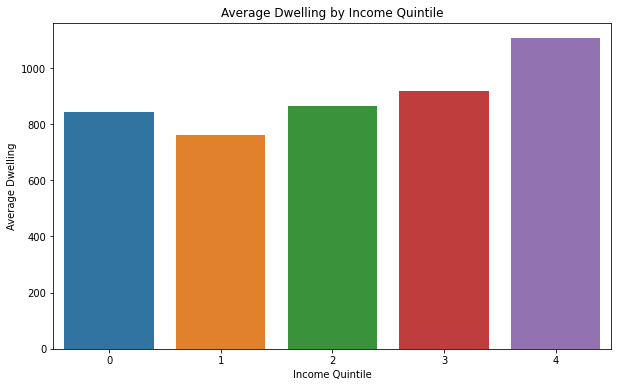

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Dwelling'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
plt.title('Average Dwelling by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Average Dwelling')
plt.show()

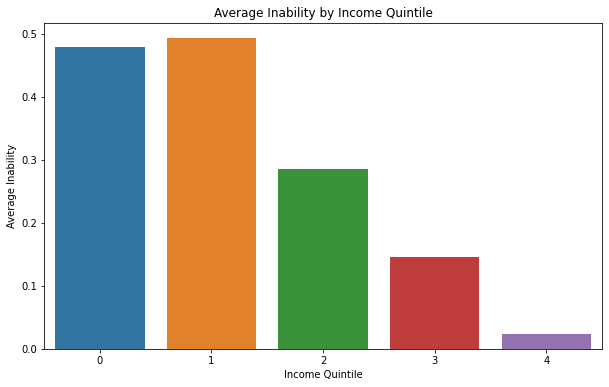

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Inability'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Inability', data=average_dwelling)
plt.title('Average Inability by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Average Inability')
plt.show()

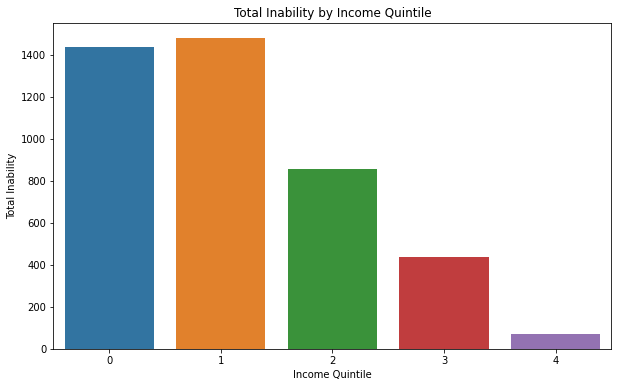

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Inability'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Inability', data=average_dwelling)
plt.title('Total Inability by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Total Inability')
plt.show()